In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import datetime
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from gensim.models import Word2Vec

C:\Users\Amit\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Data Read and Cleanup

In [2]:
# Load the data from .sqlite file

db=sqlite3.connect('database.sqlite')

# select all reviews from given dataset
# we are considering a review is positive or negative on the basis of the Score column which is nothing but a rating given
# by a customer for a product. If a score >3 it is considered as positive elseif score<3 it is negative and score=3 is neutral
# Therefore all reviews which are having score other than 3 are taken into account.

filtered_data=pd.read_sql_query("""
SELECT *
FROM Reviews WHERE Score!=3""",db)

# Replace this numbers in Score column as per our assumptions i.e replace 3+ with positive 1 and 3- with negative 0
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be positive (1) and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)


(525814, 10)


In [3]:
# converting datestamp into string representable form as YYYY-MM-DD
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d'))

In [4]:
# There is lot of duplicate data present as we can see above productId B007OSBE1U 
# have multiple duplicate reviews this is what we need to avoid.

# so first step is to sort the data and then remove duplicate entries so that only
# one copy of them should be remain in our data.
dup_free=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})
# dup_free.head()
# This is shape of our dataset of 100k datapoints after removal of dups
dup_free.shape

(364173, 10)

In [5]:
final_filtered_data=dup_free[dup_free.HelpfulnessNumerator<=dup_free.HelpfulnessDenominator]

In [6]:
final_filtered_data.shape

(364171, 10)

In [7]:
((final_filtered_data['Id'].size*1.0)/(filtered_data['Id'].size*(1.0)))*100

69.25852107399194

#### so after data cleanup we left with 69.25% data of 525k datapoints

In [8]:
filtered_data=filtered_data.sort_values(by='Time').reset_index(drop=True)

In [9]:
final=filtered_data.sample(frac=0.18,random_state=2)
final.shape

(94647, 10)

In [10]:
print("Positive Reviews: ",final[final.Score ==1].shape[0])
print("Positive Reviews: ",final[final.Score ==-1].shape[0])

Positive Reviews:  79928
Positive Reviews:  0


### Dataset seems balanced now with 52% positive reviews and 48% negative reviews

## Text Preprocessing 

In [11]:
# Now we have already done with data cleanup part. As in our dataset most cruicial or I can say most determinant feature
# from which we can say it is positive or negative review is review Text.
# So we are need to perform some Text Preprocessing on it before we actually convert it into word vector or vectorization

# I am creating some precompiled objects for our regular expressions cause it will be used for over ~64K times (in our case)
# as it seems fast but using regular expression is CPU expensive task so it would be faster to use precompiled search objects.

_wont  = re.compile(r"won't")
_cant  = re.compile(r"can\'t")
_not   = re.compile(r"n\'t")
_are   = re.compile(r"\'re")
_is    = re.compile(r"\'s")
_would = re.compile(r"\'d")
_will  = re.compile(r"\'ll")
_have  = re.compile(r"\'ve")
_am    = re.compile(r"\'m")

# we are ignoring "not" from stopwords as "not" plays important role for semantic analysis as it can alone change the 
# meaning of whole sentence
stopWords = set(stopwords.words('english'))
sw=stopWords.copy()
sw.discard('not')

def expand_abbrevated_words(phrase):
    phrase = re.sub(_wont, "will not", phrase)
    phrase = re.sub(_cant, "can not", phrase)
    phrase = re.sub(_not, " not", phrase)
    phrase = re.sub(_are, " are", phrase)
    phrase = re.sub(_is, " is", phrase)
    phrase = re.sub(_would, " would", phrase)
    phrase = re.sub(_will, " will", phrase)
    phrase = re.sub(_have, " have", phrase)
    phrase = re.sub(_am, " am", phrase)
    return phrase

# As this dataset is web scrapped from amazon.com while scrapping there might be a good chance that we are getting some garbage
# characters/words/sentences in our Text data like html tags,links, alphanumeric characters so we ought to remove them
def remove_unwanted_char(data):    
    processed_data=[]
    for sentence in tqdm(data):
        sentence = re.sub(r"http\S+", "", sentence) # this will remove links
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = re.sub("\S*\d\S*", "", sentence).strip() #remove alphanumeric words
        sentence = re.sub('[^A-Za-z]+', ' ', sentence) #remove special characters
        sentence =  expand_abbrevated_words(sentence)
        # we need to convert everything into lower case because I dont want my model to treat same word differently
        # if it appears in the begining of sentence and somewhere middle of sentence.
        # Also remove stopword froms from sentences
        sentence =" ".join(j.lower() for j in sentence.split() if j.lower() not in sw)
        processed_data.append(sentence)
    return processed_data
 
def preprocess_my_data(data):
    return remove_unwanted_char(data)
        

In [12]:
data_to_be_processed=final['Text'].values
processed_data=preprocess_my_data(data_to_be_processed)
label=final['Score']
print(len(processed_data))

100%|██████████████████████████████████████████████████████████████████████████| 94647/94647 [00:37<00:00, 2527.30it/s]


94647


In [13]:
final['CleanedText']=processed_data
print(processed_data[0])

tried several times get good coconut flavored coffee little success boyer trick great coffee good amount coconut flavor highly recommend


## Stemming

In [14]:
# Before applying BoW or Tfidf featurization techinque on our corpus we need to apply stemmming for each word in each document.
stemmed_data=processed_data.copy()
bow_stem=SnowballStemmer('english')
stemmed_reviews=[]
def stemSentence(review):
    token_words=word_tokenize(review)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(bow_stem.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

for review in tqdm(stemmed_data):
    stemmed_reviews.append(stemSentence(review))

100%|██████████████████████████████████████████████████████████████████████████| 94647/94647 [01:24<00:00, 1121.44it/s]


## Splitting Data In Train ,CV and Test Dataset

In [15]:
# To avoid data leakage we are splitting our dataset before any featurization.
x_tr, x_test, y_tr, y_test = train_test_split(stemmed_reviews, label, test_size=0.2, random_state=0)

print("Sizes of Train,test dataset after split: {0} , {1}".format(len(x_tr),len(x_test)))

Sizes of Train,test dataset after split: 75717 , 18930


## HyperParameter Tuning Using Simple Cross-Validation

In [16]:
def find_best_depth(train_data,tr_label):
    dt = DecisionTreeClassifier()
    depth=[1, 5, 10, 50, 100, 500, 100]
    min_samples_split=[5, 10, 100, 500]
    param_grid={'min_samples_split':min_samples_split,'max_depth':depth,'class_weight':['balanced']}

    tbs_cv = TimeSeriesSplit(n_splits=5).split(train_data)
    gsearch = GridSearchCV(estimator=dt, cv=tbs_cv,
                        param_grid=param_grid, scoring = 'roc_auc')
    gsearch.fit(train_data, tr_label)
    
    print("Best Depth            : ",gsearch.best_estimator_.max_depth)
    print("Best min_sample_split : ",gsearch.best_estimator_.min_samples_split)
    print("Best AUC              : ",gsearch.best_score_)
    
    test_score=gsearch.cv_results_['mean_test_score']
    train_score=gsearch.cv_results_['mean_train_score']
    
    test_score=test_score.reshape(len(depth),len(min_samples_split))
    train_score=train_score.reshape(len(depth),len(min_samples_split))
    
    plt.figure(1,figsize=(15,7))
    plt.subplot(121)
    
    depth.reverse()
    y=np.array(min_samples_split)
    sns.heatmap(test_score,xticklabels=y,yticklabels=depth,annot=test_score)
    plt.xlabel("No of samples split")
    plt.ylabel("depths")
    plt.title("Test Data AUC Scores")
    
    plt.subplot(122)
    sns.heatmap(train_score,xticklabels=y,yticklabels=depth,annot=train_score)
    plt.xlabel("No of samples split")
    plt.ylabel("depths")
    plt.title("Train Data AUC Scores")
    
    plt.show()
    return gsearch.best_estimator_.max_depth,gsearch.best_estimator_.min_samples_split

In [17]:
def testing_on_test_data(train_rev,train_label,test_rev,test_label,depth,min_samples_split):
    plt.figure(1)
    dt=DecisionTreeClassifier(max_depth=depth,min_samples_split=min_samples_split,class_weight='balanced')
    dt.fit(train_rev,train_label)  
    
    train_pred = dt.predict_log_proba(train_rev)[:,1]
    test_pred= dt.predict_log_proba(test_rev)[:,1]
    
    train_pred=np.nan_to_num(train_pred)
    test_pred=np.nan_to_num(test_pred)
    # Train data AUC value
    fpr_tr,tpr_tr, _  = roc_curve(train_label, train_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    
    # Test data AUC value
    fpr_t,tpr_t, _  = roc_curve(test_label, test_pred)
    roc_auc_t= auc(fpr_t, tpr_t)
    
    plt.plot(fpr_tr, tpr_tr, color='darkorange',
             lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_tr)
    plt.plot(fpr_t, tpr_t, color='black',
             lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_t)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Train and Test dataset')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def get_confusion_matrix(train_rev,train_label,test_rev,test_label,depth,min_samples_split):
    plt.figure(1,figsize=(15,7))
    np.set_printoptions(precision=5)
    dt=DecisionTreeClassifier(max_depth=depth,min_samples_split=min_samples_split,class_weight='balanced')
    dt.fit(train_rev,train_label)
    train_pred=dt.predict(train_rev)
    test_pred=dt.predict(test_rev)

    test_cnf_matrix=confusion_matrix(test_label,test_pred)
    train_cnf_matrix=confusion_matrix(train_label,train_pred)
    
    plt.subplot(121)
    sns.heatmap(test_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TestSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    
    plt.subplot(122)
    sns.heatmap(train_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TrainSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    plt.show()

In [19]:
def get_top_imp_features(train_rev,labels,vectorizer,depth,min_samples_split):
    dt=DecisionTreeClassifier(max_depth=depth,min_samples_split=min_samples_split,class_weight='balanced')
    dt.fit(train_rev,labels)
    top_feat=dt.feature_importances_.copy()
    top_feat.sort()
    feat_gini_map=dict(zip(dt.feature_importances_,vectorizer.get_feature_names()))
    # top 20 features
    top_20=top_feat[::-1]
    for feat in top_20[:20]:
        print(feat_gini_map[feat],end=", ")
    

In [20]:
def get_tree_visualization(train_rev,labels,vectorizer,name):
    dt=DecisionTreeClassifier(max_depth=3)
    dt.fit(train_rev,labels)  
    export_graphviz(dt, out_file=name, 
                feature_names = vectorizer.get_feature_names(),
                class_names =['Negative','Positive'],
                rounded = True, proportion = False, 
                filled = True)
    

## BoW (Bag of Words)

In [22]:
# Applying fit_transform to only train dataset as we are only because we want our vocabulary to be built only on train data
bow_count=CountVectorizer(min_df=10, max_features=300)
bow_fit=bow_count.fit(x_tr)
print("Some Feature names: ",bow_fit.get_feature_names()[:5])

#extract token count out of raw text document using vocab build using train dataset
bow_train=bow_count.transform(x_tr)
bow_test=bow_count.transform(x_test)

print("Shape of transformed train text reviews",bow_train.shape)
print("Shape of transformed test text reviews",bow_test.shape)


Some Feature names:  ['abl', 'absolut', 'actual', 'ad', 'add']
Shape of transformed train text reviews (75717, 300)
Shape of transformed test text reviews (18930, 300)


## [1.1] DecisionTree  on BOW

Best Depth            :  50
Best min_sample_split :  500
Best AUC              :  0.8081892483825975


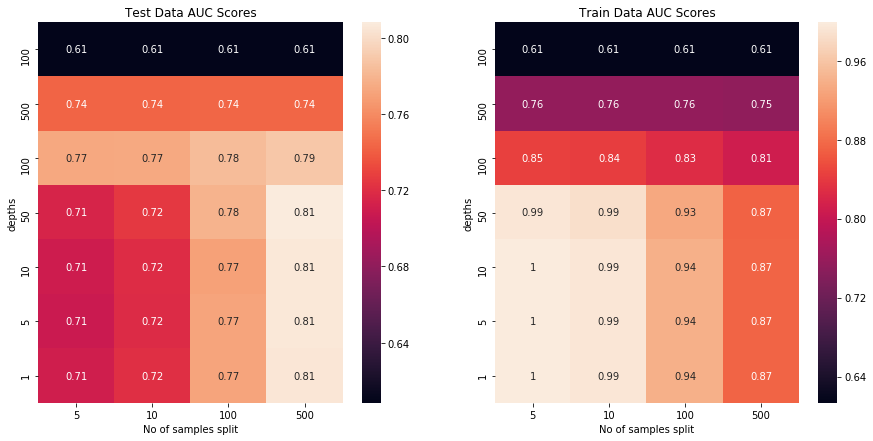

In [23]:
depth,min_samples_split=find_best_depth(bow_train,y_tr)

### [1.1.2] Top 20 Important Feature

In [24]:
get_top_imp_features(bow_train,y_tr,bow_count,depth,min_samples_split)

not, great, love, disappoint, best, delici, perfect, good, bad, favorit, nice, tast, money, review, excel, tasti, enjoy, thought, product, happi, 

### [1.1.2] Graphviz visualization of Decision Tree on BOW

In [25]:
get_tree_visualization(bow_train,y_tr,bow_fit,'bow.dot')

### [1.1.2] Testing with Test Data

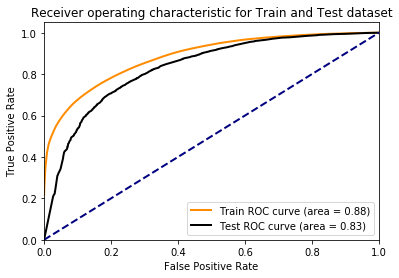

In [26]:
testing_on_test_data(bow_train,y_tr,bow_test,y_test,depth,min_samples_split)

### [1.1.5] Confusion Matrix

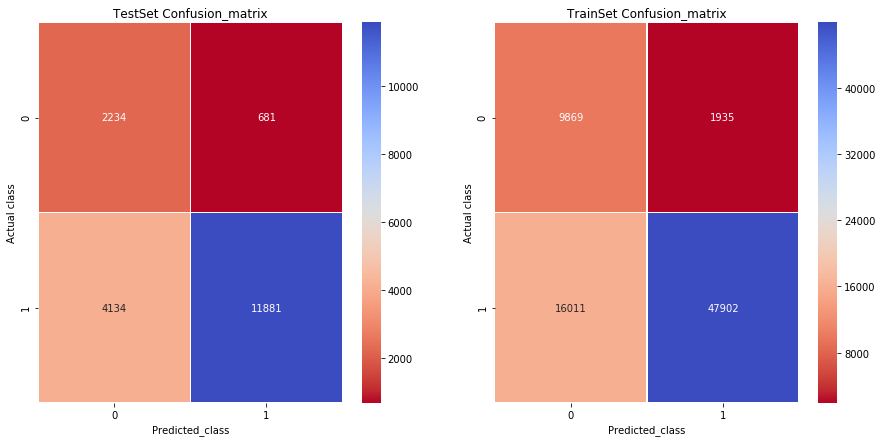

In [27]:
get_confusion_matrix(bow_train,y_tr,bow_test,y_test,depth,min_samples_split)

## [2] TFIDF

In [28]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=300,ngram_range=(2,2))
tfidf_tr=tfidf_count.fit_transform(x_tr)
tfidf_test=tfidf_count.transform(x_test)
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)


Shape of tfidf vector representation of train review text : (75717, 300)
Shape of tfidf vector representation of test review text  : (18930, 300)


### [2.1] DecisionTree on TFIDF

Best Depth            :  500
Best min_sample_split :  500
Best AUC              :  0.7427165646560355


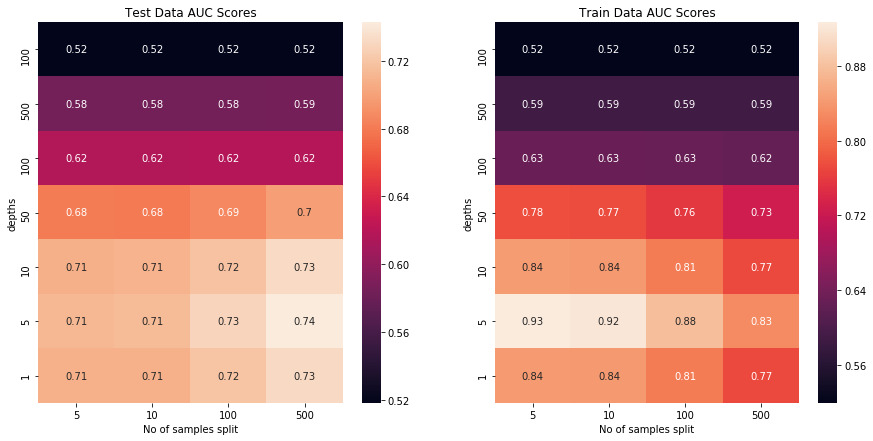

In [29]:
depth,min_samples_split=find_best_depth(tfidf_tr,y_tr)

### [2.2] Top 20 Important Feature

In [30]:
get_top_imp_features(tfidf_tr,y_tr,tfidf_count,depth,min_samples_split)

not buy, high recommend, wast money, tast like, would not, not good, tast great, great product, not recommend, not even, noth like, product not, expir date, thought would, great flavor, dog love, realli good, hard find, look like, make great, 

### [2.3] Graphviz visualization of Decision Tree on TFIDF

In [31]:
get_tree_visualization(tfidf_tr,y_tr,tfidf_count,'tfidf.dot')

### [2.4] Testing with Test Data

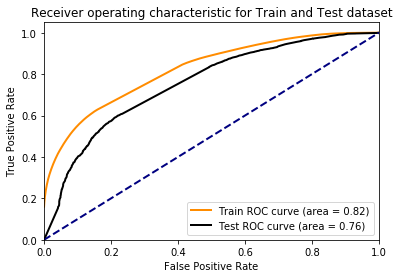

In [32]:
testing_on_test_data(tfidf_tr,y_tr,tfidf_test,y_test,depth,min_samples_split)

### [2.5] Confusion Matrix

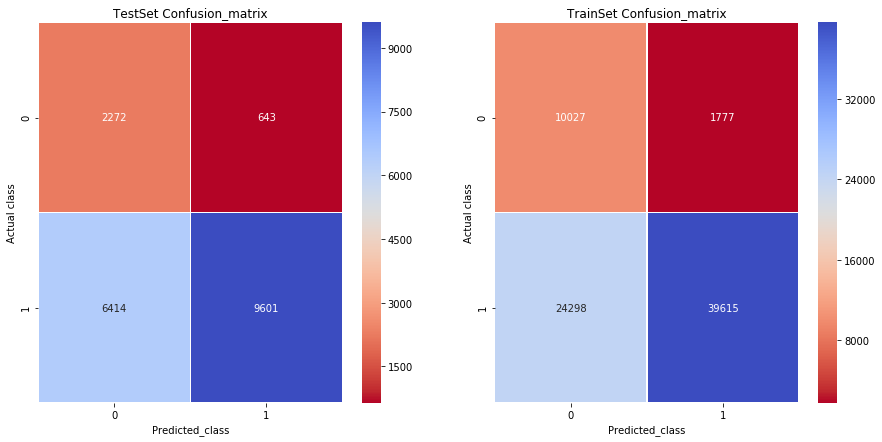

In [33]:
get_confusion_matrix(tfidf_tr,y_tr,tfidf_test,y_test,depth,min_samples_split)

## 3. Avg Word2Vec

In [34]:
# As w2vec preserves semantic meaning of words I am not going to do stemming for this.
# split each sentence from train dataset into words
reviews=x_tr.copy()
train_sentences_set=[]
for s in reviews:
    train_sentences_set.append(s.split())

In [35]:
# min_count = 10 considers only words that occured atleast 10 times
# size = dimensionality of word vectors
# workers = no of threads to use while training our w2v model/featurization
w2v_model=Word2Vec(train_sentences_set,min_count=10,size=300, workers=4)

In [36]:
w2v_words = list(w2v_model.wv.vocab)

In [37]:
def compute_avgW2Vec(reviews):
    # average Word2Vec
    # compute average word2vec for each review.
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())
        
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(rev_words): # for each review/sentence
        sent_vec = np.zeros(300) # as our w2v model is trained with size=50 i.e 50 dimension so this value will be change as dim change
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    
    return sent_vectors #Average W2v repersentation of reviews in given dataset


In [38]:
train_avgw2v=compute_avgW2Vec(x_tr) 

100%|███████████████████████████████████████████████████████████████████████████| 75717/75717 [01:18<00:00, 968.84it/s]


In [39]:
test_avgw2v=compute_avgW2Vec(x_test) 

100%|███████████████████████████████████████████████████████████████████████████| 18930/18930 [00:21<00:00, 873.37it/s]


### [3.1] Decision Tree on Avg Word2Vec

Best Depth            :  10
Best min_sample_split :  500
Best AUC              :  0.843481089325228


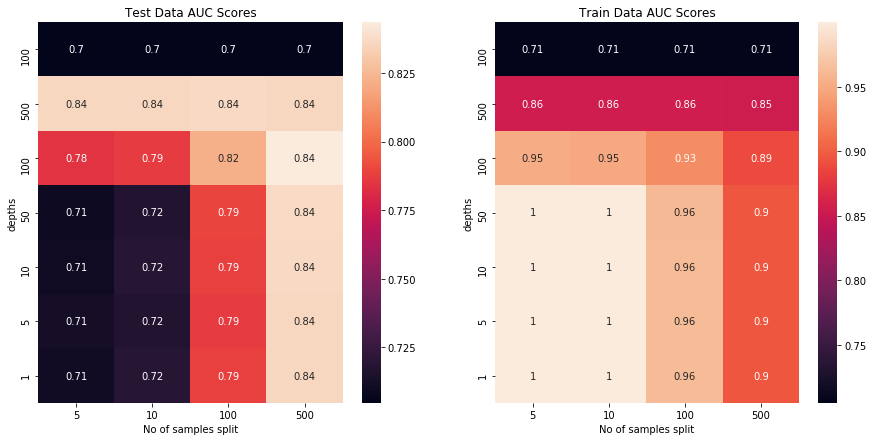

In [40]:
depth,min_samples_split=find_best_depth(train_avgw2v,y_tr)

### [3.2] Testing with Test Data

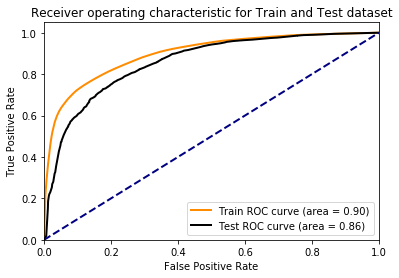

In [41]:
testing_on_test_data(train_avgw2v,y_tr,test_avgw2v,y_test,depth,min_samples_split)

 ### [3.3] Confusion Matrix

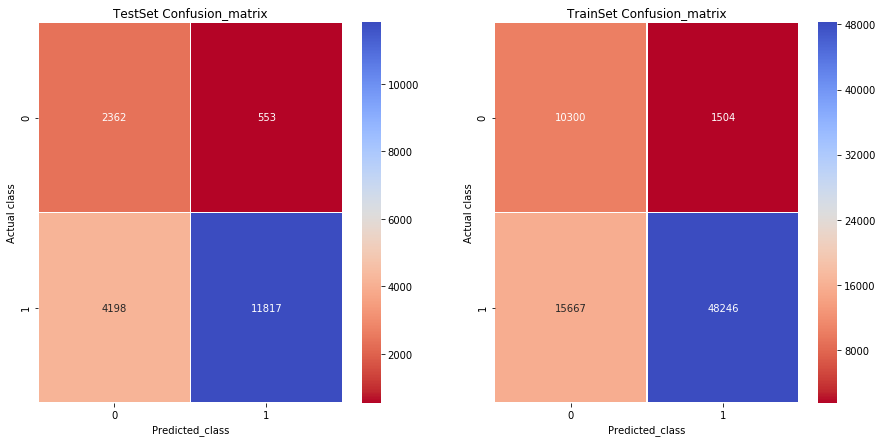

In [42]:
get_confusion_matrix(train_avgw2v,y_tr,test_avgw2v,y_test,depth,min_samples_split)

## [4] Avg TFIDF W2VEC

In [43]:
tfidf_w2v = TfidfVectorizer(min_df=10,max_features=300)
tfidf_w2v.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_w2v.get_feature_names(), list(tfidf_w2v.idf_)))
tfidf_feat = tfidf_w2v.get_feature_names() # tfidf words/col-names

In [44]:
def compute_tfidf_w2vec(reviews):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    rev_words=[]
    for i in reviews:
        rev_words.append(i.split())
        
    for sent in tqdm(rev_words): # for each review/sentence 
        sent_vec = np.zeros(300) #as our w2v model is trained with size=50 i.e 500 dimension so this value will be change as dim change
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf values of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    
    return tfidf_sent_vectors

In [45]:
train_tfidf_w2v=compute_tfidf_w2vec(x_tr) 

100%|███████████████████████████████████████████████████████████████████████████| 75717/75717 [02:18<00:00, 546.65it/s]


In [46]:
test_tfidf_w2v=compute_tfidf_w2vec(x_test) 

100%|███████████████████████████████████████████████████████████████████████████| 18930/18930 [00:34<00:00, 546.13it/s]


 ### [4.1] Decision Tree on TFIDF weighted W2Vec

Best Depth            :  10
Best min_sample_split :  500
Best AUC              :  0.7622673711328964


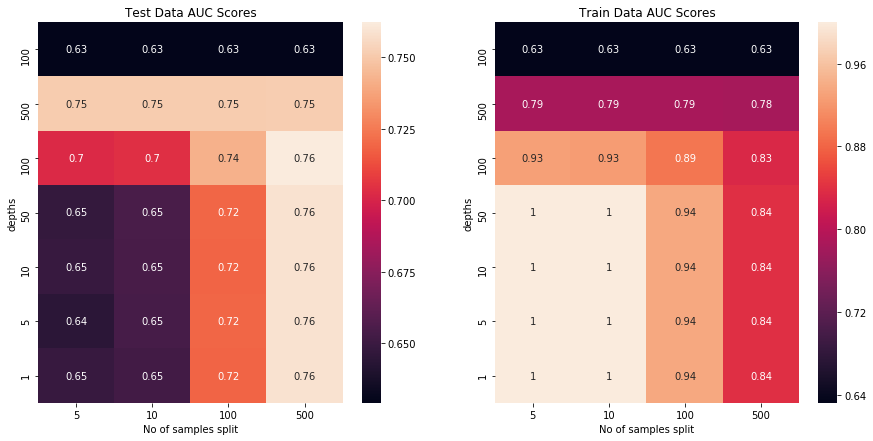

In [47]:
depth,min_samples_split=find_best_depth(train_tfidf_w2v,y_tr)

 ### [4.2] Testing with Test Data

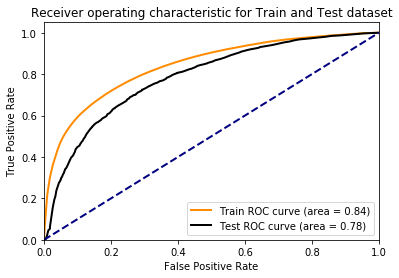

In [48]:
 testing_on_test_data(train_tfidf_w2v,y_tr,test_tfidf_w2v,y_test,depth,min_samples_split)

 ### [4.3] Confusion Matrix

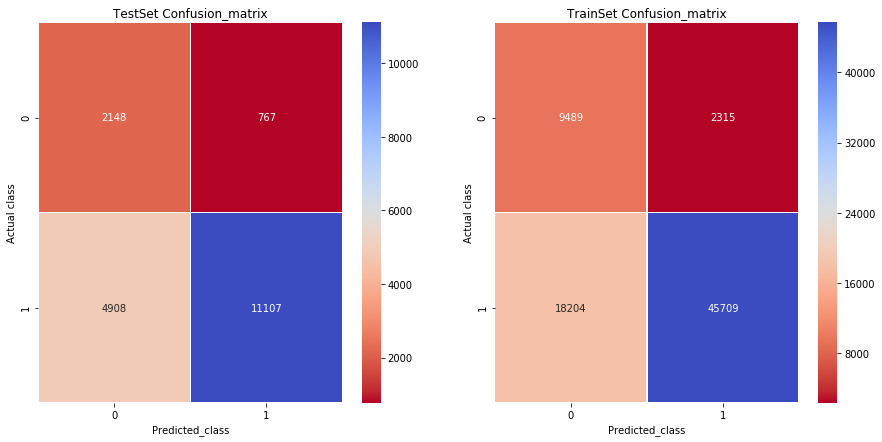

In [49]:
 get_confusion_matrix(train_tfidf_w2v,y_tr,test_tfidf_w2v,y_test,depth,min_samples_split)

## Feature Engineering

Till we have seen AUC score for Avg tfidf vectorized reviews being least among all, so we can try to improve this by adding some more features like review length

In [50]:
# Adding review text length as feature to check if model performance increases further.
feature_eng=[]
for x in tqdm(stemmed_reviews):
    x_split=x.split()
    feature_eng.append(len(x_split))

100%|████████████████████████████████████████████████████████████████████████| 94647/94647 [00:00<00:00, 159856.79it/s]


In [51]:
df={'Reviews':stemmed_reviews,'Review_Length':feature_eng}

In [52]:
new_data=pd.DataFrame(df)
new_data.head()

,Reviews,Review_Length
0,tri sever time get good coconut flavor coffe l...,20
1,jack link sweet hot jerki geratest jerki ever ...,24
2,came across product bjs fell love food never t...,31
3,qualiti great tast larabar still prefer cherri...,15
4,get trader joe chocol crave delici like break ...,13


In [53]:
# To avoid data leakage we are splitting our dataset before any featurization.
x_tr, x_test, y_tr, y_test = train_test_split(new_data, label, test_size=0.3, random_state=0)

print("Sizes of Train,test dataset after split: {0} , {1}".format(len(x_tr),len(x_test)))

Sizes of Train,test dataset after split: 66252 , 28395


In [54]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=300,ngram_range=(2,2))
tfidf_tr=tfidf_count.fit_transform(x_tr['Reviews'])
tfidf_test=tfidf_count.transform(x_test['Reviews'])
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)


Shape of tfidf vector representation of train review text : (66252, 300)
Shape of tfidf vector representation of test review text  : (28395, 300)


### Train Data

In [55]:
type(tfidf_tr)

scipy.sparse.csr.csr_matrix

In [56]:
train_rev_df=pd.DataFrame(tfidf_tr.toarray().tolist())
tr_rev_len=pd.DataFrame(x_tr['Review_Length'],columns=['Review_Length'])
# Setting same indexes as NaN values are getting added in Review_Length column due to different indexes for dataframes
train_rev_df=train_rev_df.set_index(tr_rev_len.index)

In [57]:
train_rev_df['Review_Length']=tr_rev_len['Review_Length']
train_rev_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Review_Length
47464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95
17924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
59233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
87663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43
69318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23


### Test Data

In [58]:
test_rev_df=pd.DataFrame(tfidf_test.toarray().tolist())
test_rev_len=pd.DataFrame(x_test['Review_Length'],columns=['Review_Length'])
# Setting same indexes as NaN values are getting added in Review_Length column due to different indexes for dataframes
test_rev_df=test_rev_df.set_index(test_rev_len.index)

In [59]:
test_rev_df['Review_Length']=test_rev_len['Review_Length']
test_rev_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Review_Length
58711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44
59248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
70263,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
41149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
75106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34


### Hyperparameter Tuning

Best Depth            :  100
Best min_sample_split :  500
Best AUC              :  0.7368073065873717


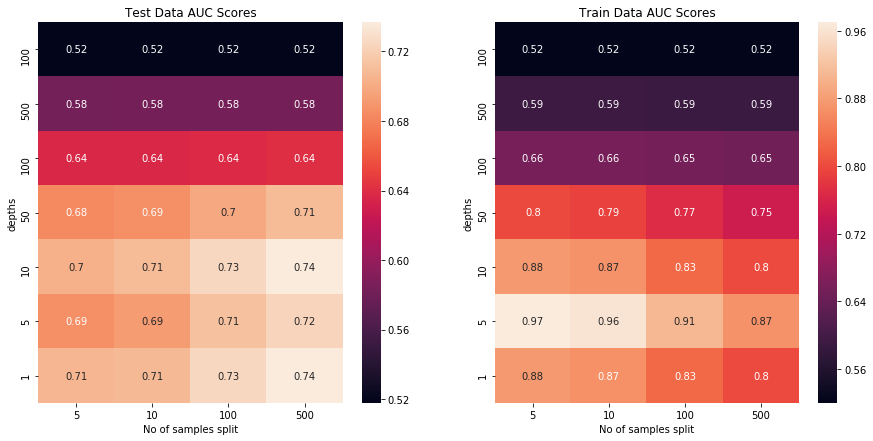

In [60]:
depth,min_samples_split=find_best_depth(train_rev_df,y_tr)

### Testing on Test data

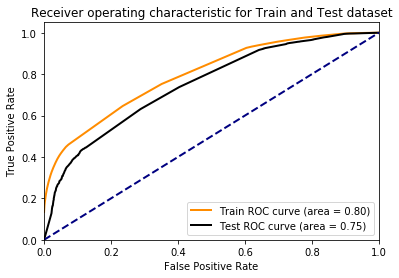

In [61]:
 testing_on_test_data(train_rev_df,y_tr,test_rev_df,y_test,depth,min_samples_split)

### Confusion Matrix

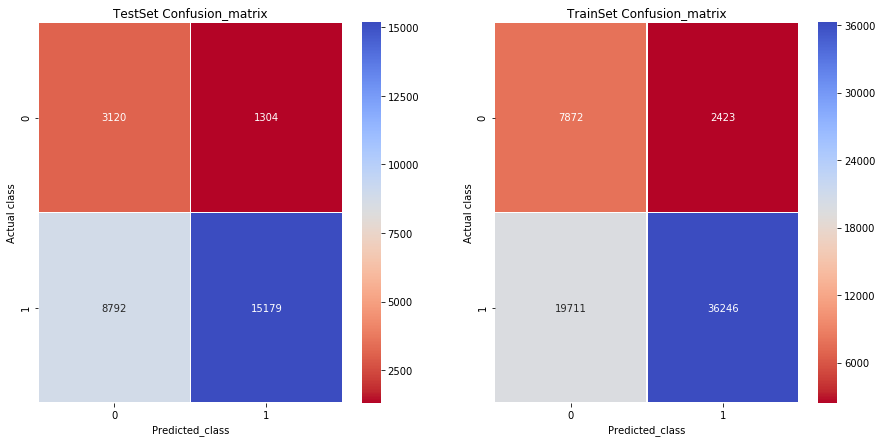

In [62]:
 get_confusion_matrix(train_rev_df,y_tr,test_rev_df,y_test,depth,min_samples_split)

we can see after adding one more feature(Review_Length) performance of our model for TFIDF Vectorized reviews remain unchanged

## Summary

In [64]:
print("""
          |  Vectorizer    |    depth       |  min_samples_split  |      AUC                 |
          ____________________________________________________________________________________

              BoW          |    50          |     500              |      0.8081892483825975 |
             tfidf         |    500         |     500              |      0.7427165646560355 |
            Avg tfidf      |    10          |     500              |      0.843481089325228  |
        tfidf Weighted W2v |    10          |     500              |      0.7622673711328964 |
           tfidf(FE)       |    100         |     500              |      0.7368073065873717 |

""")


          |  Vectorizer    |    depth       |  min_samples_split  |      AUC                 |
          ____________________________________________________________________________________

              BoW          |    50          |     500              |      0.8081892483825975 |
             tfidf         |    500         |     500              |      0.7427165646560355 |
            Avg tfidf      |    10          |     500              |      0.843481089325228  |
        tfidf Weighted W2v |    10          |     500              |      0.7622673711328964 |
           tfidf(FE)       |    100         |     500              |      0.7368073065873717 |




### Conclusion:

1. Decision Tree is non- linear algorithm.

2. It is basically set of axis parallel lines/planes/hyperplanes which tesselect our region into cubes/hypercubes.

3. Decision Trees can be imagined as simple nested if-else statement as decision are made up depending upon threshold values at each node

4. Splitting of node depends upon Maximum Information Gain or Minimum Gini Impurity. DecisionTreeRegressor by default uses Gini as criterio to split our nodes.

5. Gini Impurity basically similar as Entropy. In this at splitting node we need subsets which are less impure i.e less randomness so that our decision will be more accurate.

6. For DT's there are number hyperparameters can be taken into account such as max_depth, min_sample_split,max_leaf_node,min_weight_fraction. Here we have used max_depth and max_leaf_node

7. max_depth restricts depth of decision tree i.e our decision tree will only be of max_depth level.

8. min_samples_leaf imposes the minimum number of samples to be present at splitting node.

9. If depth is too high and minimum number of samples at leaf node is too small our model will overfit

10. If depth is too small then there are high chances of model will underfit

11. Decision Trees are not suitable for high dimensional data but very useful large datasets.